In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.special import softmax

In [2]:
%matplotlib inline

In [3]:
np.random.seed(0)

# Helper functions

In [4]:
def relu(X):
    return np.maximum(0, X)

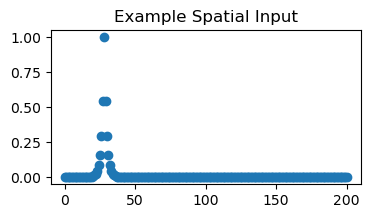

In [5]:
def make_bump(size, center):
    """ Generates an exponential fall off """
    
    assert(center < size)
    x = np.linspace(0, 15)
    halfbump = np.exp(-2*x)
    halfbump = halfbump/halfbump.max()
    bump = np.zeros(size)
    bump[:halfbump.size] = halfbump
    bump[-halfbump.size+1:] = halfbump[1:][::-1]
    offset = 0.
    bump = bump - offset
    bump[bump < 0] = 0
    bump /= bump.max()
    bump = np.roll(bump, center)
    return bump

plt.figure(figsize=(4,2))
plt.scatter(np.arange(201), make_bump(201, 28))
plt.title('Example Spatial Input')
plt.show()

# Dynamics Function

In [6]:
def get_activity(T, i, softmax_temp=1):
    """
    Runs T timesteps of dynamics given
    constant input i
    """
    
    x = x_prev = np.zeros(N)
    x_prev = i
    activities = []
    for t in range(T):
        x = J@(0.95*x_prev) + i
        x[b_start:b_end] = softmax(x[b_start:b_end]*softmax_temp)
        x[b_start:b_end] -= softmax_offset
        x = relu(x)
        x_prev = x
        activities.append(x)
    return activities

# Modifiable Parameters

In [7]:
n_spatial = 201
n_barcode = 801
n_cache = 1
T = 30 # Number of timesteps to simulate
softmax_offset = 0.02
softmax_action_gain = 15

In [8]:
seed_locs = [int(n_spatial*0.3), int(n_spatial*0.5)]
print(f'Caches at locations {seed_locs}')

Caches at locations [60, 100]


In [9]:
connection_p = 0.005 # Probability

# Network initializations

In [10]:
N = n_spatial + n_barcode + n_cache
J = np.zeros((N, N)) # (s,b,c) ordering

# Defining useful indices
s_start = 0
s_end = n_spatial
b_start = s_end
b_end = b_start + n_barcode
c_start = b_end
c_end = -1
SEED = c_start

In [11]:
# Set sparse spatial-barcode connections

for i in range(n_spatial):
    chosen_bs = np.random.binomial(
        n=1, p=connection_p, size=n_barcode)
    chosen_bs = np.argwhere(chosen_bs).flatten()
    #chosen_bs = np.random.choice(n_barcode, size=3, replace=False)
    n_bs = chosen_bs.size
    if n_bs == 0: continue
    J_val = 1./n_bs
    if i in seed_locs:
        print(f'Spatial cell {i} connects to barcodes {chosen_bs}')
    J[b_start + chosen_bs, s_start+i] = J_val
J[s_start:s_end, b_start:b_end] = J[b_start:b_end, s_start:s_end].T

Spatial cell 100 connects to barcodes [185 286 448 545]


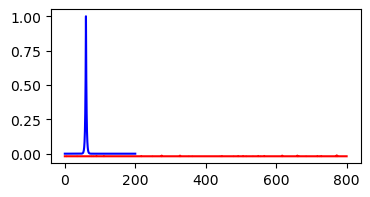

Cache cell connects to barcodes [] to represent spatial cell 60


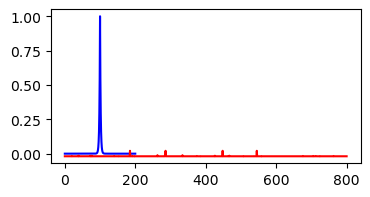

Cache cell connects to barcodes [185 286 448 545] to represent spatial cell 100


In [12]:
# Set barcode-cache connections

space_to_bar = {}
for l in seed_locs:
    bump = make_bump(n_spatial, l)
    b_activations = J[b_start:b_end, s_start:s_end]@bump
    b_activations = softmax(b_activations*softmax_action_gain) - softmax_offset
    #chosen_bs = np.argwhere(b_activations == b_activations.max()).flatten()
    chosen_bs = np.argwhere(b_activations>0).flatten()
    J[b_start + chosen_bs, l] = 1#/chosen_bs.size
    J[l, b_start + chosen_bs] = 1#/chosen_bs.size    
    J[b_start + chosen_bs, SEED] = 1#/chosen_bs.size
    J[SEED, b_start + chosen_bs] = 1#/chosen_bs.size
    space_to_bar[l] = chosen_bs
    plt.figure(figsize=(4,2))
    plt.plot(bump, color='blue')
    plt.plot(b_activations, color='red')
    plt.show()
    print(f'Cache cell connects to barcodes {chosen_bs} to represent spatial cell {l}')

# Capacity Plots-- No Barcode Gain

In [13]:
temp = 1

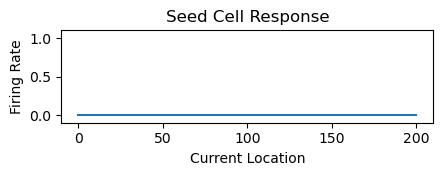

In [14]:
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.25))
seed_cell_activity = []
for loc in np.arange(n_spatial):
    _input = np.zeros(N)
    _input[s_start:s_end] = make_bump(n_spatial, loc)
    activities = get_activity(T, _input, softmax_temp=temp)
    activity_T = activities[-1] # Select just the last timestep of dynamics
    seed_cell_activity.append(activity_T[SEED])
ax.plot(seed_cell_activity)
ax.set_title('Seed Cell Response')
ax.set_xlabel('Current Location')
ax.set_ylabel('Firing Rate')
ax.set_ylim(-0.1, 1.1)
plt.show()

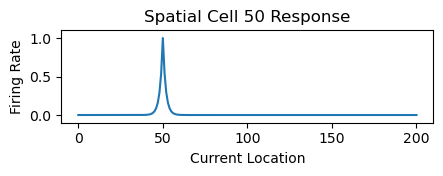

In [15]:
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.25))
seed_cell_activity = []
for loc in np.arange(n_spatial):
    _input = np.zeros(N)
    _input[s_start:s_end] = make_bump(n_spatial, loc)
    activities = get_activity(T, _input, softmax_temp=temp)
    activity_T = activities[-1] # Select just the last timestep of dynamics
    seed_cell_activity.append(activity_T[s_start+50])
ax.plot(seed_cell_activity)
ax.set_title('Spatial Cell 50 Response')
ax.set_xlabel('Current Location')
ax.set_ylabel('Firing Rate')
ax.set_ylim(-0.1, 1.1)
plt.show()

# Capacity Plots-- With Barcode Gain

In [16]:
temp = softmax_action_gain

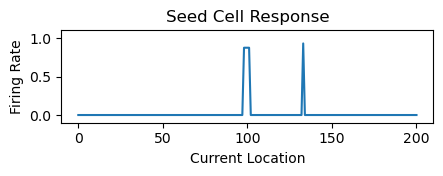

In [17]:
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.25))
seed_cell_activity = []
for loc in np.arange(n_spatial):
    _input = np.zeros(N)
    _input[s_start:s_end] = make_bump(n_spatial, loc)
    activities = get_activity(T, _input, softmax_temp=temp)
    activity_T = activities[-1] # Select just the last timestep of dynamics
    seed_cell_activity.append(activity_T[SEED])
ax.plot(seed_cell_activity)
ax.set_title('Seed Cell Response')
ax.set_xlabel('Current Location')
ax.set_ylabel('Firing Rate')
ax.set_ylim(-0.1, 1.1)
plt.show()

# Memory Plots

In [18]:
test_loc = int(seed_locs[0] + (seed_locs[1]-seed_locs[0])*0.3)
seed_strength = 10
print(f'Testing memory at location {test_loc}')
print(f'Seed input is of strength {seed_strength}')

Testing memory at location 72
Seed input is of strength 10


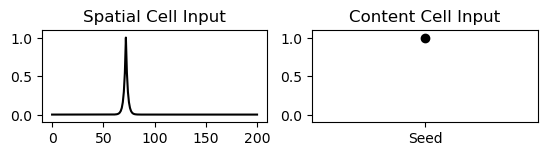

In [19]:
spatial_input = make_bump(n_spatial, test_loc)
fig, axs = plt.subplots(1, 2, figsize=(6.4, 4.8*0.25))
axs[0].plot(spatial_input, color='k')
axs[1].scatter([0], [1], color='k')
axs[0].set_title('Spatial Cell Input')
axs[1].set_title('Content Cell Input')
axs[1].set_xticks([0], ['Seed'])
for ax in axs:
    ax.set_ylim(-.1, 1.1)
plt.show()

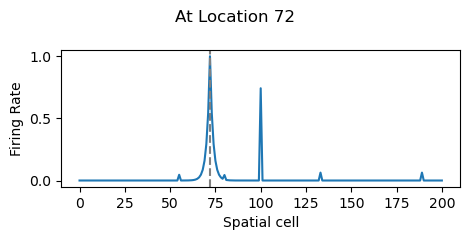

In [20]:
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.5))
_input = np.zeros(N)
_input[s_start:s_end] = make_bump(n_spatial, test_loc)
_input[SEED] = 6
activities = get_activity(T, _input, softmax_temp=1)
activity_T = activities[-1]
ax.plot(activity_T[s_start:s_end])
ax.set_xlabel('Spatial cell')
ax.set_ylabel('Firing Rate')
ax.axvline(test_loc, color='gray', linestyle='--')
plt.suptitle(f'At Location {test_loc}')
plt.tight_layout()
plt.show()

In [21]:
from scipy.stats import pearsonr

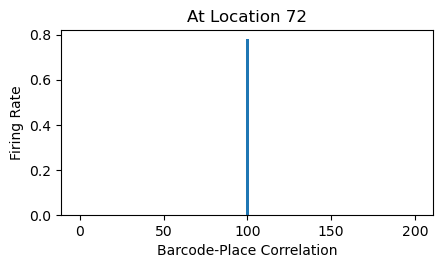

In [22]:
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.5))
corrs = []
for spatial_loc in np.arange(n_spatial):
    barcode = np.zeros(n_barcode)
    if spatial_loc not in space_to_bar.keys():
        corr = 0
    else:
        for b in space_to_bar[spatial_loc]:
            barcode[b] = 1
        corr = np.dot(activity_T[b_start:b_end], barcode)
        #corr = pearsonr(activity_T[b_start:b_end], barcode)[0]
    corrs.append(corr)
ax.bar(np.arange(n_spatial), corrs, width=2)
ax.set_xlabel('Barcode-Place Correlation')
ax.set_ylabel('Firing Rate')
ax.set_title(f'At Location {test_loc}')
plt.show()